# SLU15: Feature Engineering

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

import category_encoders as ce

# 1. Tidy data principles

At the beginning of any project, it is critical to structure datasets in a way that facilitates work.

The ideas of ***tidy data*** ([Wickham, 2014](http://vita.had.co.nz/papers/tidy-data.html)) provide a standardized framework to organize and structure datasets, making them easy to manipulate, model and visualize.
1. Each variable forms a column;
2. Each observation forms a row;
3. Each type of observational unit forms a table (or dataframe).


**Load the data**

In [2]:
avengers = pd.read_csv('data/avengers.csv')
avengers.head()

,Name,Active,Gender,Membership,Universe,Appearances,TotalDeaths,TotalReturns
0,"Henry Jonathan ""Hank"" Pym",YES,MALE,Full,Earth-616,1269,1,0
1,Janet van Dyne,YES,FEMALE,Full,Earth-616,1165,1,1
2,"Anthony Edward ""Tony"" Stark",YES,MALE,Full,Earth-616,3068,1,1
3,Robert Bruce Banner,YES,MALE,Full,Earth-616,2089,1,1
4,Thor Odinson,YES,MALE,Full,Earth-616,2402,2,1


# 2. Data representation in Pandas

There are two main types of statistical variables:
1. Numerical;
2. Categorical.

Regardless of the kind of variable, it may be represented in pandas by one of the following main data types:
* Numeric (`int`, `float`);
* Datetime (`datetime`, `timedelta`);
* String (`object`).

The `dtypes` attribute return the dtypes in the DataFrame and the `select_dtypes` method allows us to select variables (columns in our dataframe) by data type.

In [5]:
avengers.dtypes

Name            object
Active          object
Gender          object
Membership      object
Universe        object
Appearances      int64
TotalDeaths      int64
TotalReturns     int64
dtype: object

In [6]:
avengers.select_dtypes(include='object').head()

,Name,Active,Gender,Membership,Universe
0,"Henry Jonathan ""Hank"" Pym",YES,MALE,Full,Earth-616
1,Janet van Dyne,YES,FEMALE,Full,Earth-616
2,"Anthony Edward ""Tony"" Stark",YES,MALE,Full,Earth-616
3,Robert Bruce Banner,YES,MALE,Full,Earth-616
4,Thor Odinson,YES,MALE,Full,Earth-616


## 2.1. Data type conversion

### Between numeric types  

Use [`.astype()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html#pandas.DataFrame.astype).

In [14]:
avengers.Appearances.astype('int32').head(3)

0    1269
1    1165
2    3068
Name: Appearances, dtype: int32

### String to numeric and vice versa  

Use [`.astype()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html#pandas.DataFrame.astype) or [`.map()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html).

In [15]:
avengers.Appearances.astype(str).head(3)

0    1269
1    1165
2    3068
Name: Appearances, dtype: object

In [16]:
avengers.Appearances.astype(str).astype(int).head(3)

0    1269
1    1165
2    3068
Name: Appearances, dtype: int32

In [37]:
avengers['Gender'].map({'MALE': 1, 'FEMALE': 0}).head(3)

0    1
1    0
2    1
Name: Gender, dtype: int64

In [39]:
avengers.assign(Active_mapped = avengers['Active'].map({'YES': 1, 'NO': 0}),
                 Gender_mapped = avengers['Gender'].map({'MALE': 1, 'FEMALE': 0})).sample(5)

,Name,Active,Gender,Membership,Universe,Appearances,TotalDeaths,TotalReturns,Active_mapped,Gender_mapped
17,Heather Douglas,NO,FEMALE,Full,Earth-616,332,2,2,0,0
120,Johnny Gallo,YES,MALE,Academy,Earth-616,43,0,0,1,1
88,"Dorrek VIII/Theodore ""Teddy"" Altman",YES,MALE,Full,Earth-616,110,0,0,1,1
123,Brandon Sharpe,YES,MALE,Academy,Earth-616,64,0,0,1,1
11,Heracles,YES,MALE,Full,Earth-616,741,0,0,1,1


### String to date  

Use pandas [`pd.to_datetime()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html)

In [18]:
date_Series = pd.Series(['10/05/1985','01/04/1988','01/01/2019','15/12/1985'])
date_Series

0    10/05/1985
1    01/04/1988
2    01/01/2019
3    15/12/1985
dtype: object

In [19]:
pd.to_datetime(date_Series, format='%d/%m/%Y')

0   1985-05-10
1   1988-04-01
2   2019-01-01
3   1985-12-15
dtype: datetime64[ns]

### String to category  

Pandas provide us with a `category` dtype for categorical data. The advantages of using it:
* Easily identify and signal categorical columns for processing and other Python libraries;
* Converting a string variable with a few different values to a categorical variable saves memory;
* By converting to a categorical we can specify an order on the categories.

Let's consider a categorical feature: `Universe`.

In [23]:
avengers_cat = avengers.copy()
avengers_cat['Universe_cat'] = avengers_cat.Universe.astype('category')

avengers_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 9 columns):
Name            155 non-null object
Active          155 non-null object
Gender          155 non-null object
Membership      155 non-null object
Universe        155 non-null object
Appearances     155 non-null int64
TotalDeaths     155 non-null int64
TotalReturns    155 non-null int64
Universe_cat    155 non-null category
dtypes: category(1), int64(3), object(5)
memory usage: 10.3+ KB


In [29]:
avengers_cat['Universe_cat'].sample(5)

79    Earth-616
16    Earth-616
30    Earth-616
64    Earth-616
94    Earth-616
Name: Universe_cat, dtype: category
Categories (7, object): [Earth-13034, Earth-616, Earth-6311, Earth-691, Earth-8009, Earth-921, Earth-96020]

# 3. Operations on Data

## Numerical data

In a Data Science project, you will deal with a dataset, on which you will apply transformations (***feature engineering!***) and, after that, you will train your Machine Learning model.  

Some transformations are easy to manage: for example, replacing the missing values on a given column (using pandas `fillna()` method) by a fixed value (say `0`).   

> **In this case it is trivial to apply the same transformation on new, unseen data (test set or unlabeled data).**  

> **But imagine that instead you are filling the missing values with the median value of that feature. How do you apply that transformation in practice?**

You have to do it in two steps:
* You compute the median of that feature for the *training data* and fill the missing values with that value;
* For new unseen data (e.g. the test set), you just fill the missing value with the median you calculated for the *training data*.

This process is greatly facilitated by using `sklearn`-like **transformers**, which have two standard methods:
* The `.fit()` method goes through the data and creates a mapping;
* Then `.transform()` transforms the data using this mapping, failing gracefully you when strange things happen (e.g., unseen values or categories).  

`from sklearn.preprocessing import KBinsDiscretizer`  
`from sklearn.preprocessing import Binarizer`  
`from sklearn.preprocessing import MinMaxScaler`  
`from sklearn.preprocessing import Normalizer`  
`from sklearn.preprocessing import StandardScaler`  
`from sklearn.preprocessing import RobustScaler`  

The different possible transformations are:
* **Binning**: Is the transformation of continuous data into *intervals* or *bins*.
* **Binarization**: The same but only with two bins, below and above a threshold.
* [**MinMaxScaler**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler): This transforms all variables so that the minimum and the maximum of the transformed data take certain values $[a,b]$, say, [0, 1].
* [**Normalizer**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html): This normalizes each ***row*** of the dataset *individually* to unit norm, independently of the other rows.
* [**StandardScaler**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler): Standardization means both centering the data around 0 (by removing the mean) and scaling it to unit variance, $ z_i =  \frac{x_i - \mu}{\sigma}$.
* [**RobustScaler**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler): In the presence of some very large ***outliers***, using the scaler above leads to the compression of inliers. Since outliers have an influence on the minimum, maximum, mean and standard deviation, these scalers will shrink the range of the feature values. The alternative is to scale the features in a way that is robust to outliers: using the *median* (instead of the *mean*) and the Interquartile Range *('member SLU04?)*.

Let's see an example using `StandardScaler`.

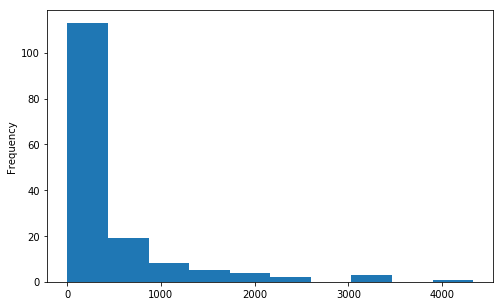

In [62]:
# plot histogram of the original data
avengers['Appearances'].plot.hist(figsize=(8, 5));

C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()


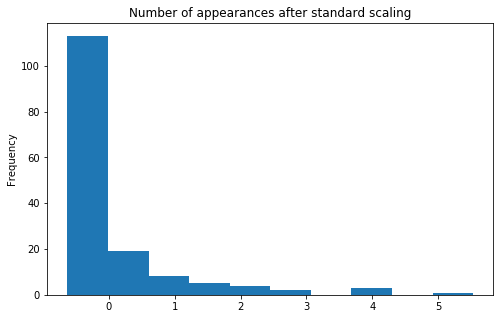

In [61]:
# initialize transformer with desired options
standardscaler = StandardScaler()

# save data to scale
X = avengers[['Appearances']]

# fit transformer to data
standardscaler.fit(X)

# create new feature by transforming the data
avengers['Appearances_standard_scaled'] = standardscaler.transform(X)

# plot histogram
avengers['Appearances_standard_scaled'].plot.hist(figsize=(8, 5));
plt.title('Number of appearances after standard scaling');

## Categorical data

A limitation of categorical data in the form of strings is that estimators, in general, don't know how to deal with it.  
Another one is that strings require way more memory to be stored!  

There are also transformers to deal with categorical features. Even though `sklearn` contains some of such transformers, there is a (much) better library which you shoud (must!) use instead, [`category_encoders`](https://contrib.scikit-learn.org/categorical-encoding/):  

`import category_encoders as ce`  

> **Advantages of using transformers for encoding:**
> * Assurance that the mapping between the category and its code will be preserved when encoding the test set or unseen data.
> * Automatic handle of unknown categories.

We have two main kind of encoders:
* [**OrdinalEncoder**](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html): encodes a categorical feature as an ordinal, integer feature, by mapping a number to each category. It uses a single column of integers, chosen randomly by default, to represent the classes.
* [**OneHotEncoder**](https://contrib.scikit-learn.org/categorical-encoding/onehot.html): creates one new feature per *each category*. With ordinal enconding, as described above, a Machine Learning algorithm values a category whose encoding is `8` as more important than one with encoding `2`! With one-hot encoding each new feature is either `0` or `1`.

In [40]:
avengers['Universe'].unique()

array(['Earth-616', 'Earth-691', 'Earth-6311', 'Earth-921', 'Earth-96020',
       'Earth-8009', 'Earth-13034'], dtype=object)

In [54]:
# initialize transformer with desired options
ordinalencoder = ce.ordinal.OrdinalEncoder()

# save data to scale (no need to reshape)
X = avengers['Universe']

# fit transformer to data
ordinalencoder.fit(X)

# create new feature by transforming the datab
X_encoded = ordinalencoder.transform(X)

# The result
pd.concat([X_encoded, avengers['Universe']], axis=1, sort=False).sample(5)

,Universe,Universe
154,1,Earth-616
54,1,Earth-616
75,1,Earth-616
120,1,Earth-616
58,1,Earth-616


If you want to see the mapping which was created:

In [59]:
ordinalencoder.category_mapping

[{'col': 'Universe', 'mapping': Earth-616      1
  Earth-691      2
  Earth-6311     3
  Earth-921      4
  Earth-96020    5
  Earth-8009     6
  Earth-13034    7
  NaN           -2
  dtype: int64, 'data_type': dtype('O')}]

We applied the transformation on the same data we fit the transformer. What would happen if we tried to transform an instance with an ***unseen category***, say `Earth-123` or `Earth-999`?

In [60]:
ordinalencoder.transform(pd.DataFrame({'Universe': ['Earth-6311', 'Earth-123', 'Earth-999']}))

,Universe
0,3.0
1,-1.0
2,-1.0
